In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import os
import torch.nn as nn
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from preprocessing_util import preposs_toekn, Lang, text2index, construct_Lang
from Multilayers_Encoder import EncoderRNN
from Multilayers_Decoder import DecoderRNN, DecoderAtten
#from config import device, PAD_token, SOS_token, EOS_token, UNK_token, embedding_freeze, vocab_prefix
import random
from evaluation import evaluate_batch, evaluate_beam_batch
import pickle 
from config import *

In [3]:
model_address = '/scratch/tw1682/NLP/Model/vi-en-12-linear-dot/epoch_9.pth'
config_address = '/scratch/tw1682/NLP/Model/vi-en-12-linear-dot/model_params.pkl'
transtype = ('vi', 'en')
check_point_state = torch.load(model_address)
with open(config_address, 'rb') as f:
    paras = pickle.load(f)

In [4]:
src_max_vocab_size = paras['src_max_vocab_size']
tgt_max_vocab_size = paras['tgt_max_vocab_size']
tgt_max_len = paras['tgt_max_len']
max_src_len_dataloader = paras['max_src_len_dataloader']
max_tgt_len_dataloader = paras['max_tgt_len_dataloader']

teacher_forcing_ratio = paras['teacher_forcing_ratio']
emb_size = paras['emb_size']
hidden_size = paras['hidden_size']
num_layers = paras['num_layers']
num_direction = paras['num_direction']
deal_bi = paras['deal_bi']
learning_rate = paras['learning_rate']
num_epochs = paras['num_epochs']
batch_size = paras['batch_size']
attention_type = paras['attention_type']
beam_size = paras['beam_size']
model_save_info = paras['model_save_info']
dropout_rate = paras['dropout_rate']

# address_book=dict(
#     train_src = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/train.tok.{}'.format(transtype[0], transtype[1], transtype[0]),
#     train_tgt = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/train.tok.{}'.format(transtype[0], transtype[1], transtype[1]),
#     val_src = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/dev.tok.{}'.format(transtype[0], transtype[1], transtype[0]),
#     val_tgt = 'Machine_Translation_NLP/iwsltzhen/iwslt-{}-{}/dev.tok.{}'.format(transtype[0], transtype[1], transtype[1]),
#     src_emb = 'embedding/wiki.{}.vec'.format(transtype[0]),
#     tgt_emb = 'embedding/wiki.{}.vec'.format(transtype[1])
#     )
#print(address_book)
train_src_add = address_book['train_src']
train_tgt_add = address_book['train_tgt']
val_src_add = address_book['val_src']
val_tgt_add = address_book['val_tgt']

# make dir for saving models
if not os.path.exists(model_save_info['model_path']):
    os.makedirs(model_save_info['model_path'])
### save model hyperparameters
with open(model_save_info['model_path']+'model_params.pkl', 'wb') as f:
    model_hyparams = paras
    model_hyparams['address_book'] = address_book
    pickle.dump(model_hyparams, f)
print(model_hyparams)

train_src = []
with open(train_src_add) as f:
    for line in f:
        train_src.append(preposs_toekn(line[:-1].strip().split(' ')))

train_tgt = []
with open(train_tgt_add) as f:
    for line in f:
        train_tgt.append(preposs_toekn(line[:-1].strip().split(' ')))

val_src = []
with open(val_src_add) as f:
    for line in f:
        val_src.append(preposs_toekn(line[:-1].strip().split(' ')))

val_tgt = []
with open(val_tgt_add) as f:
    for line in f:
        val_tgt.append(preposs_toekn(line[:-1].strip().split(' ')))

print('The number of train samples: ', len(train_src))
print('The number of val samples: ', len(val_src))
srcLang = construct_Lang('src', src_max_vocab_size, address_book['src_emb'], train_src)
tgtLang = construct_Lang('tgt', tgt_max_vocab_size, address_book['tgt_emb'], train_tgt)
#train_input_index = text2index(train_src, srcLang.word2index) #add EOS token here 
#train_output_index = text2index(train_tgt, tgtLang.word2index)
val_input_index = text2index(val_src, srcLang.word2index)
val_output_index = text2index(val_tgt, tgtLang.word2index)

{'src_max_vocab_size': 26109, 'tgt_max_vocab_size': 24418, 'tgt_max_len': 100, 'max_src_len_dataloader': 72, 'max_tgt_len_dataloader': 71, 'emb_size': 300, 'hidden_size': 256, 'num_layers': 1, 'num_direction': 2, 'deal_bi': 'linear', 'attention_type': 'dot_prod', 'teacher_forcing_ratio': 1, 'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 100, 'beam_size': 1, 'dropout_rate': 0.1, 'model_save_info': {'model_path': 'nmt_models/vi-en-12-linear-dot/', 'epochs_per_save_model': 10, 'model_path_for_resume': None}, 'address_book': {'train_src': '/home/tw1682/Machine_Translation_NLP/iwsltzhen/iwslt-vi-en/train.tok.vi', 'train_tgt': '/home/tw1682/Machine_Translation_NLP/iwsltzhen/iwslt-vi-en/train.tok.en', 'val_src': '/home/tw1682/Machine_Translation_NLP/iwsltzhen/iwslt-vi-en/dev.tok.vi', 'val_tgt': '/home/tw1682/Machine_Translation_NLP/iwsltzhen/iwslt-vi-en/dev.tok.en', 'src_emb': '/scratch/tw1682/embedding/wiki.vi.vec', 'tgt_emb': '/scratch/tw1682/embedding/wiki.en.vec'}}
The number of 

In [5]:
if paras["attention_type"]:
    encoder = EncoderRNN(srcLang.vocab_size, emb_size, hidden_size, num_layers, num_direction, deal_bi, embedding_weight = None, dropout_rate = dropout_rate)
    decoder = DecoderAtten(emb_size, hidden_size, tgtLang.vocab_size, num_layers, embedding_weight = None, atten_type = attention_type, dropout_rate = dropout_rate)
else:      
    encoder = EncoderRNN(srcLang.vocab_size, emb_size,hidden_size, num_layers, num_direction, deal_bi, embedding_weight = None, dropout_rate = dropout_rate)
    decoder = DecoderRNN(emb_size, hidden_size, tgtLang.vocab_size, num_layers, embedding_weight = None, dropout_rate = dropout_rate)
    

dot_prod


In [6]:
encoder.load_state_dict(check_point_state['encoder_state_dict'])
decoder.load_state_dict(check_point_state['decoder_state_dict'])

In [7]:
from Data_utils import VocabDataset, vocab_collate_func

In [8]:
val_dataset = VocabDataset(val_input_index,val_output_index, None, None)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=1,
                                        collate_fn=vocab_collate_func,
                                        shuffle=False)

In [9]:
encoder, decoder = encoder.to(device), decoder.to(device)

In [12]:
# criterion = nn.NLLLoss()
# val_bleu_sacre, val_bleu_nltk, val_loss = evaluate_batch(val_loader, encoder, decoder, criterion, tgt_max_len, tgtLang.index2word, srcLang.index2word)


In [42]:
import sacrebleu
import beam
def fun_index2token(index_list, idx2words):
    token_list = []
    for index in index_list:
        if index == EOS_token:
            break
        else:
            token_list.append(idx2words[index])
    return token_list

def visulization(loader, encoder, decoder, tgt_max_length, tgt_idx2words, src_idx2words):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    tgt_sents_sacre = []
    tgt_pred_sents_sacre = []
    src_sents = []
    atten_weight_list = []
    true_prob_list = []
    with torch.no_grad():
        for input_tensor, input_lengths, target_tensor, target_lengths in loader:
            atten_weights = []
            true_prob = []
            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden, input_lengths)
            decoder_input = torch.tensor([[SOS_token]*batch_size], device=device).transpose(0,1)
            decoder_hidden = encoder_hidden
            decoding_token_index = 0
            target_lengths_numpy = target_lengths.cpu().numpy()
            idx_token_pred = np.zeros((batch_size, tgt_max_length), dtype=np.int)
            while decoding_token_index < tgt_max_length:
                decoder_output, decoder_hidden, weight = decoder(decoder_input, decoder_hidden, input_lengths, encoder_outputs)  
                if decoding_token_index < target_tensor.size(1):
                    true_index = target_tensor[0,decoding_token_index].cpu().item()
                    true_prob.append(decoder_output[0,true_index])
                atten_weights.append(np.array(weight.squeeze(0).squeeze(0)))
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()  # detach from history as input
                idx_token_pred_step = decoder_input.cpu().squeeze(1).numpy()
                idx_token_pred[:, decoding_token_index] = idx_token_pred_step
                decoding_token_index += 1
                end_or_not = idx_token_pred_step != EOS_token
                sent_not_end_index = list(np.where(end_or_not)[0])
                if len(sent_not_end_index) == 0:
                    break
            true_prob_list.append(true_prob)
            atten_weight_list.append(atten_weights)
            target_tensor_numpy = target_tensor.cpu().numpy()
            input_tensor_numpy = input_tensor.cpu().numpy()
            for i_batch in range(batch_size):
                tgt_sent_tokens = fun_index2token(target_tensor_numpy[i_batch].tolist(), tgt_idx2words) #:target_lengths_numpy[i_batch]
                tgt_sents_sacre.append(' '.join(tgt_sent_tokens))
                tgt_pred_sent_tokens = fun_index2token(idx_token_pred[i_batch].tolist(), tgt_idx2words)
                tgt_pred_sents_sacre.append(' '.join(tgt_pred_sent_tokens))
                src_sent_tokens = fun_index2token(input_tensor_numpy[i_batch].tolist(), src_idx2words)
                src_sents.append(' '.join(src_sent_tokens))
    sacre_bleu_score = sacrebleu.corpus_bleu(tgt_pred_sents_sacre, [tgt_sents_sacre], smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
        tokenize='none', use_effective_order=True)
    if True:
        random_sample = np.random.randint(len(tgt_pred_sents_sacre))
        print('src:', src_sents[random_sample])
        print('Ref: ', tgt_sents_sacre[random_sample])
        print('pred: ', tgt_pred_sents_sacre[random_sample])
        print('sacre_bleu_score',sacre_bleu_score)
    return src_sents, tgt_sents_sacre, tgt_pred_sents_sacre, atten_weight_list,true_prob_list


In [43]:
src_sents, tgt_sents_sacre, tgt_pred_sents_sacre, atten_weight_list,true_prob_list = visulization(val_loader, encoder, decoder, tgt_max_len, tgtLang.index2word, srcLang.index2word)


src: Nó nằm trên một dải đất mà chúng_tôi gọi_là đường đi_dạo .
Ref:  It was on a strip of land that we call a <UNK> .
pred:  It &apos;s on a valley of the ground we &apos;re calling a <UNK> .
sacre_bleu_score BLEU(score=21.88761539707461, counts=[15032, 7317, 3892, 2120], totals=[27018, 25750, 24482, 23216], precisions=[55.63698275223925, 28.415533980582524, 15.897394003757864, 9.131633356305995], bp=1.0, sys_len=27018, ref_len=26728)


In [50]:
aaa = np.array(atten_weight_list[0])

In [51]:
aaa.shape

(34, 31)

In [22]:
import matplotlib.pyplot as plt

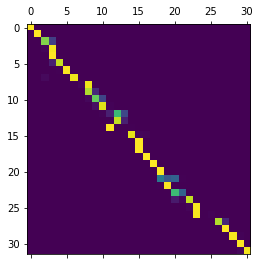

In [23]:
plt.matshow(aaa)

In [46]:
len(src_sents[0].split(' '))

30

In [47]:
len(tgt_sents_sacre[0].split(' '))

30

In [67]:
for i in range(100,120):
    print(tgt_pred_sents_sacre[i])
    print(tgt_sents_sacre[i])
    print()

Samuel 16 . I <UNK> . I &apos;m a very good fortune . I &apos;m a great kid .
Samuel is 16 . He &apos;s tall . He &apos;s very handsome .

I have a great memory .
He has the most <UNK> memory .

But it &apos;s selection .
He has a selective one , though .

I don &apos;t remember if I had <UNK> goggles -- my uncles , not , but remember the year &apos; <UNK> songs , the <UNK> between us from her home , my favorite talks from her home , the first <UNK> to the <UNK> , and the birthday of the OED <UNK> <UNK> .
He doesn &apos;t remember if he stole my chocolate bar , but he remembers the year of release for every song on my iPod , conversations we had when he was four , <UNK> on my arm on the first ever episode of <UNK> , and Lady Gaga &apos;s birthday .

Now , this sounds great , right ?
Don &apos;t they sound incredible ?

But most people don &apos;t agree .
But most people don &apos;t agree .

And actually because of my mind , I wasn &apos;t suited to the normal , but they often get out a

In [131]:
len(tgt_sents_sacre[1].split(' '))

6

In [69]:
true_prob_list[113]

[tensor(-0.0602, device='cuda:0'),
 tensor(-1.6541, device='cuda:0'),
 tensor(-0.8539, device='cuda:0'),
 tensor(-0.4758, device='cuda:0'),
 tensor(-0.0029, device='cuda:0'),
 tensor(-7.1340, device='cuda:0'),
 tensor(-9.4733, device='cuda:0'),
 tensor(-10.1679, device='cuda:0'),
 tensor(-13.8375, device='cuda:0'),
 tensor(-13.8696, device='cuda:0'),
 tensor(-4.9662, device='cuda:0'),
 tensor(-13.0475, device='cuda:0'),
 tensor(-13.3779, device='cuda:0'),
 tensor(-14.5309, device='cuda:0'),
 tensor(-14.4447, device='cuda:0')]

In [57]:
len(tgt_pred_sents_sacre[0].split(' '))

33

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [200]:
a = np.ones(3)

In [202]:
np.concatenate((a, [1]), axis=0)

array([ 1.,  1.,  1.,  1.])

In [204]:
a = [1,2,3]

In [205]:
b = a + [4,]

In [206]:
b[0] = -100

In [208]:
b

[-100, 2, 3, 4]